# PC-GMM Composites

In [1]:
from importlib import reload
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy as ctp

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../paper.mplstyle")


In [2]:
# Load weights
weight_month_mean = xr.open_dataset(
    "../output/pcgmm/pcgmm_1stpaperdraft/pcgmm_weights_month_sst.nc"
)['p_c_given_x']
gmm_order = weight_month_mean.attrs['gmm_sort']


In [8]:
# Load data
# =======================================================================================
reload(preproc)
vars = ['sst', 'ssh', 'olr']
climatology = 'month'
f_sst = "../data/reanalysis/monthly/ERA5/sea_surface_temperature_era5_monthly_sp_1940-2022_1.0x1.0.nc"

datapath = {
    'sst':    f"../data/reanalysis/monthly/ORAS5/sea_surface_temperature_oras5_single_level_1958_2023_1x1.nc",
    'ssh':    f"../data/reanalysis/monthly/ORAS5/sea_surface_height_oras5_single_level_1958_2023_1x1.nc",
    't2m':    f"../data/reanalysis/monthly/ERA5/2m_temperature_era5_monthly_sp_1940-2022_2.5x2.5.nc",
    'olr':    f"../data/reanalysis/monthly/ERA5/olr_era5_monthly_sp_1940-2022_2.5x2.5.nc",
}

da4comp_arr = []
for var in vars:
    print(f"Load {var}")
    temp = preproc.process_data(
        datapath[var], vars=[var], antimeridian=False,
        lon_range=[-180, 179], lat_range=[-80, 80],
        grid_step=2.5, climatology=climatology, normalization=None
    )
    temp = temp[f"{var}a"]
    temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
    da4comp_arr.append(temp)
ds4comp = xr.merge(da4comp_arr)


Load sst
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Get selected area: lon=[-180, 179], lat=[-80, 80]!
Interpolate grid on res 2.5
Detrend and compute anomalies:
Load ssh
Sort longitudes and latitudes in ascending order, respectively
Process ssh:


/tmp/ipykernel_86877/3825168604.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_86877/3825168604.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convert

Get selected area: lon=[-180, 179], lat=[-80, 80]!
Interpolate grid on res 2.5
Detrend and compute anomalies:
Load olr
Sort longitudes and latitudes in ascending order, respectively
Process olr:


/tmp/ipykernel_86877/3825168604.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_86877/3825168604.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convert

Get selected area: lon=[-180, 179], lat=[-80, 80]!
Interpolate grid on res 2.5
Detrend and compute anomalies:


/tmp/ipykernel_86877/3825168604.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp['time'] = np.array(temp['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_86877/3825168604.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by convert

In [9]:
ds4comp

<xarray.Dataset>
Dimensions:  (time: 1000, lat: 65, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2023-04-01
  * lat      (lat) float64 -80.0 -77.5 -75.0 -72.5 -70.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 12.0 1.0 2.0 3.0 4.0
Data variables:
    ssta     (time, lat, lon) float64 nan nan nan ... -0.02225 -0.02271
    ssha     (time, lat, lon) float64 nan nan nan nan ... 0.1217 0.112 0.1017
    olra     (time, lat, lon) float64 0.1085 0.8155 1.652 2.356 ... nan nan nan

## Probabilistic weighted composites

In [4]:
# Parameters
n_samples_mean = 100
alpha = 0.05
null_hypothesis = 'neutral'
stattest = 'pos'
multiple_testing= 'dunn'

In [5]:
# Weighted composites
reload(utenso)
composites_prob, mask_prob, samples_null_prob, pvals_prob = utenso.get_weighted_composites(
    ds4comp, f_sst, weight_month_mean, null_hypothesis=null_hypothesis,
    stattest=stattest, n_samples_mean=n_samples_mean, alpha=alpha,
    multiple_testing=multiple_testing, serial_data=False
)


/home/jakob/Code/LatentGMM/latgmm/utils/utenso.py:1158: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  weights['time'] = np.array(weights['time'].data, dtype='datetime64[M]')
/home/jakob/Code/LatentGMM/latgmm/utils/utenso.py:1158: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable co

Sort longitudes and latitudes in ascending order, respectively
Len of null-times: 26
Compute mean and stat-test for ssta
Num of samples for null hypothesis: 173
Percentile of score for c=1


100%|██████████| 9360/9360 [00:06<00:00, 1338.41it/s]


Num of samples for null hypothesis: 108
Percentile of score for c=2


100%|██████████| 9360/9360 [00:06<00:00, 1369.72it/s]


Num of samples for null hypothesis: 12
Percentile of score for c=3


100%|██████████| 9360/9360 [00:06<00:00, 1405.31it/s]


Num of samples for null hypothesis: 141
Percentile of score for c=4


100%|██████████| 9360/9360 [00:06<00:00, 1368.97it/s]


Num of samples for null hypothesis: 161
Percentile of score for c=5


100%|██████████| 9360/9360 [00:06<00:00, 1361.50it/s]


Compute mean and stat-test for ssha
Num of samples for null hypothesis: 173
Percentile of score for c=1


100%|██████████| 9360/9360 [00:06<00:00, 1404.07it/s]


Num of samples for null hypothesis: 108
Percentile of score for c=2


100%|██████████| 9360/9360 [00:06<00:00, 1396.98it/s]


Num of samples for null hypothesis: 12
Percentile of score for c=3


100%|██████████| 9360/9360 [00:06<00:00, 1400.50it/s]


Num of samples for null hypothesis: 141
Percentile of score for c=4


100%|██████████| 9360/9360 [00:06<00:00, 1440.84it/s]


Num of samples for null hypothesis: 161
Percentile of score for c=5


100%|██████████| 9360/9360 [00:06<00:00, 1430.98it/s]


Compute mean and stat-test for olra
Num of samples for null hypothesis: 173
Percentile of score for c=1


100%|██████████| 9360/9360 [00:06<00:00, 1430.90it/s]


Num of samples for null hypothesis: 108
Percentile of score for c=2


100%|██████████| 9360/9360 [00:06<00:00, 1422.82it/s]


Num of samples for null hypothesis: 12
Percentile of score for c=3


100%|██████████| 9360/9360 [00:06<00:00, 1425.60it/s]


Num of samples for null hypothesis: 141
Percentile of score for c=4


100%|██████████| 9360/9360 [00:06<00:00, 1459.52it/s]


Num of samples for null hypothesis: 161
Percentile of score for c=5


100%|██████████| 9360/9360 [00:06<00:00, 1447.29it/s]


/tmp/ipykernel_86877/3139588880.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/pcgmm/pcgmm_weighted_composites.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_86877/3139588880.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/pcgmm/pcgmm_weighted_composites.png", dpi=300, bbox_inches='tight')
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


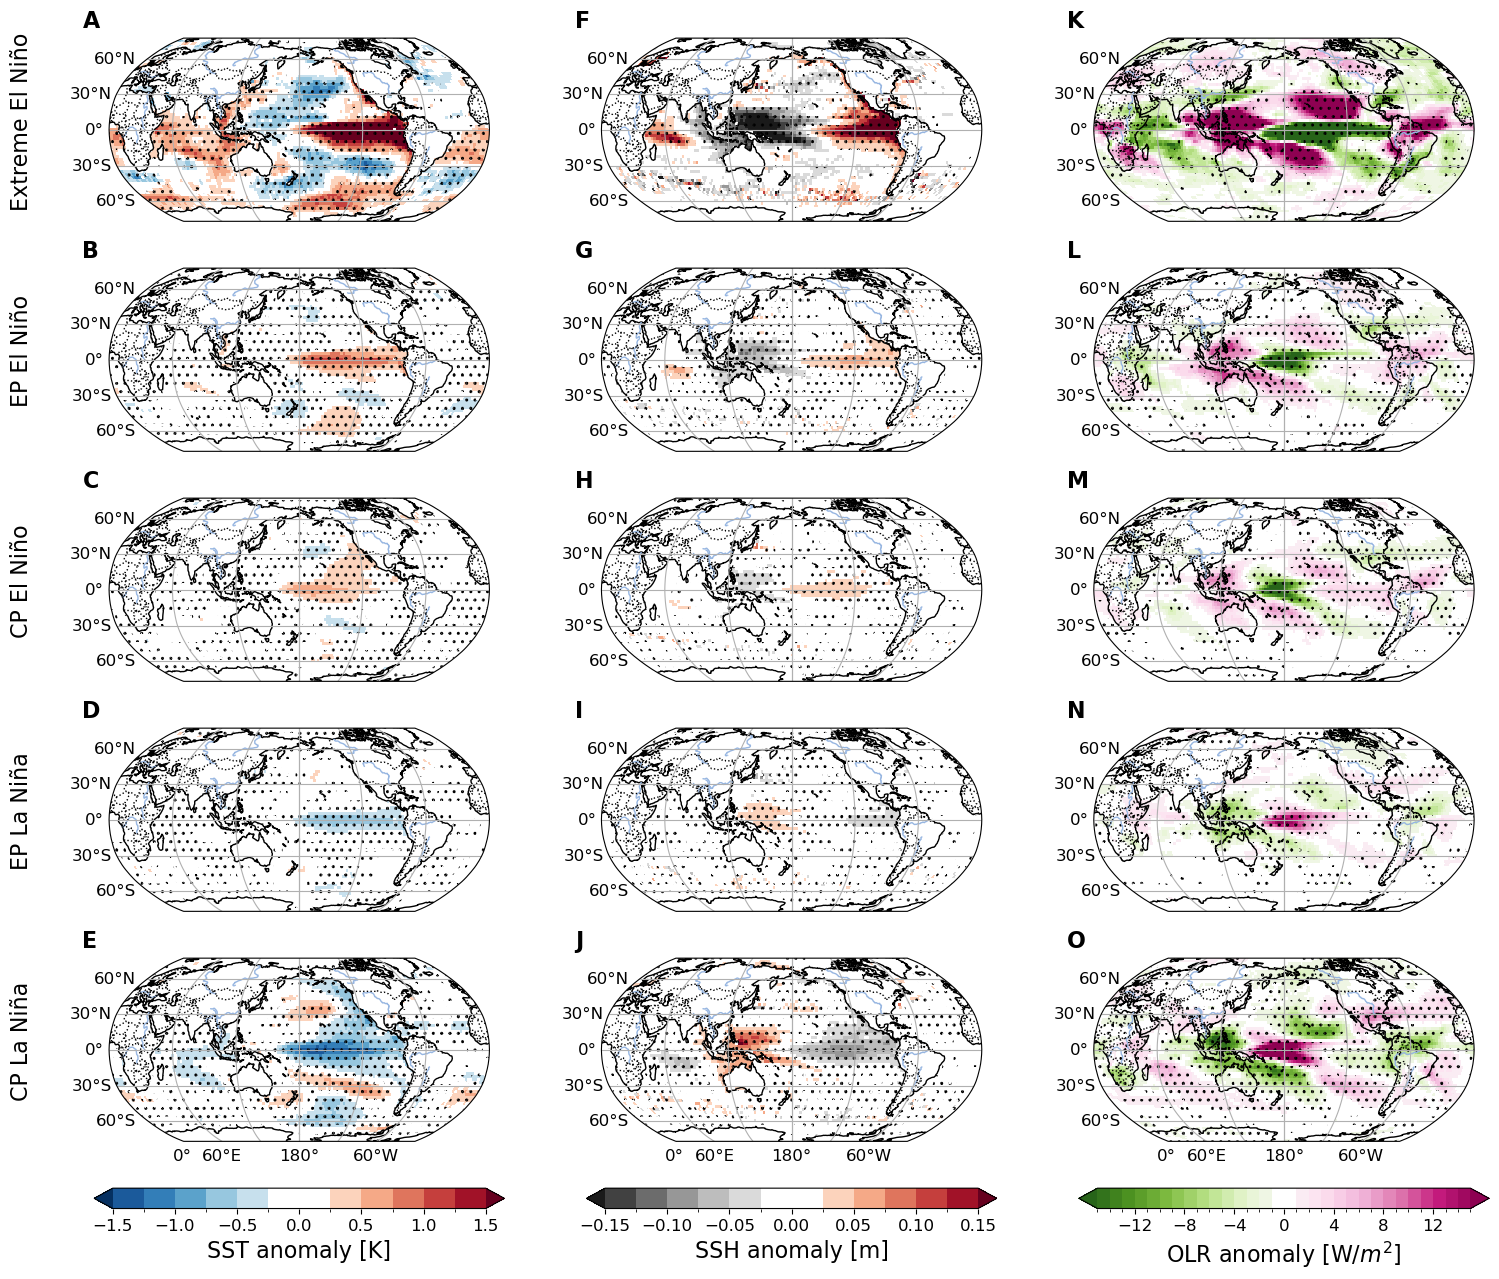

In [6]:
# Plot weighted composites
# ===============================================
plotspec = {
    'ssta': dict(cmap='RdBu_r', vmin=-1.5, vmax=1.5, step=.25, label='SST anomaly [K]'),
    'ssha': dict(cmap='RdGy_r', vmin=-.15, vmax=.15, step=.025, label='SSH anomaly [m]'),
    't2ma': dict(cmap='RdBu_r', vmin=None, vmax=None, step=.25, label='2m temperature anomaly'),
    'olra': dict(cmap='PiYG_r', vmin=-15, vmax=15, step=1, label=r'OLR anomaly [W/$m^2$]'),
}
labels = ["Extreme El Niño" ,"EP El Niño", "CP El Niño", "EP La Niña", "CP La Niña"]
n_columns = len(composites_prob.data_vars)
n_rows = len(composites_prob['classes'])
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3 + 0.2))
gs = fig.add_gridspec(n_rows + 1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)
central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)

axs = []
for j in range(n_columns):
    for i in range(n_rows):
        idx = gmm_order[i] + 1
        var = list(composites_prob.data_vars)[j]
        comp = composites_prob[var].sel(classes=idx)
        mask = mask_prob[var].sel(classes=idx)
        ax = fig.add_subplot(gs[i, j], projection=proj)

        im = gpl.plot_map(comp, central_longitude=0, ax=ax,
                          bar='discrete', add_bar=False,
                          cmap=plotspec[var]['cmap'],
                          vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                          step=plotspec[var]['step'], centercolor='#FFFFFF')
        gpl.significance_mask(mask, ax=ax, hatch="..",
                              central_longitude=0)
        # Remove labels
        im['gl'].top_labels = False
        im['gl'].right_labels = False
        if i == n_rows-1:
            im['gl'].bottom_labels = True
        else:
            im['gl'].bottom_labels = False
        axs.append(ax)

        if j == 0:
            ax.text(-0.2, 0.55, rf"{labels[i]}", va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, fontsize=16) 

    # Shared colorbar
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.3,
                        cax=ax, extend='both')
    cbar.set_label(f"{plotspec[var]['label']}", size=16)

_ = gpl.enumerate_subplots(np.array(axs).T, pos_x=-
                           0.07, pos_y=1.06, fontsize=16)

plt.savefig("../output/pcgmm/pcgmm_weighted_composites.png", dpi=300, bbox_inches='tight')

## Unweighted composites

In [ ]:
# Unweighted composites
reload(utenso)
composites_unweight, mask_unweight, composites_null, samples_null_unweight, pvalues_unweight = utenso.get_unweighted_composites(
    ds4comp, f_sst, stattest=stattest, null_hypothesis=null_hypothesis,
    n_samples_mean=n_samples_mean, alpha=alpha,
    serial_data=False, multiple_testing=multiple_testing
)


In [ ]:
# Plot unweighted composites
plotspec = {
    'ssta': dict(cmap='RdBu_r', vmin=-1.5, vmax=1.5, step=.1, label='SST anomaly [K]'),
    'ssha': dict(cmap='RdGy_r', vmin=-.15, vmax=.15, step=.01, label='SSH anomaly [m]'),
    't2ma': dict(cmap='RdBu_r', vmin=None, vmax=None, step=.25, label='2m temperature anomaly'),
    'olra': dict(cmap='PiYG_r', vmin=-15, vmax=15, step=1, label=r'OLR anomaly [W/$m^2$]'),
}

n_columns = len(composites_unweight.data_vars)
n_rows = len(composites_unweight['classes']) + 1
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3 + 0.2))
gs = fig.add_gridspec(n_rows+1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)
central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)

labels = ["EP El Niño", "CP El Niño", "EP La Niña", "CP La Niña"]
axs = []
for j in range(n_columns):
    var = list(composites_unweight.data_vars)[j]

    # Neutral composites
    ax = fig.add_subplot(gs[0, j], projection=proj)
    im = gpl.plot_map(composites_null[var], central_longitude=0, ax=ax,
                      bar='discrete', add_bar=False,
                      cmap=plotspec[var]['cmap'],
                      vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                      step=plotspec[var]['step'], centercolor='#FFFFFF')
    if j == 0:
        ax.text(-0.2, 0.55, rf"Neutral", va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes, fontsize=16) 
    axs.append(ax)

    im['gl'].top_labels = False
    im['gl'].right_labels = False
    im['gl'].bottom_labels = False

    # ENSO flavor composites
    for i in range(len(composites_unweight['classes'])):
        comp = composites_unweight[var].isel(classes=i)
        mask = mask_unweight[var].isel(classes=i)
        ax = fig.add_subplot(gs[i+1, j], projection=proj)

        im = gpl.plot_map(comp, central_longitude=0, ax=ax,
                          bar='discrete', add_bar=False,
                          cmap=plotspec[var]['cmap'],
                          vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                          step=plotspec[var]['step'], centercolor='#FFFFFF')
        gpl.significance_mask(mask, ax=ax,
                              central_longitude=0)
        # Remove labels
        im['gl'].top_labels = False
        im['gl'].right_labels = False
        if i+1 == n_rows-1:
            im['gl'].bottom_labels = True
        else:
            im['gl'].bottom_labels = False
        
        if j == 0:
            ax.text(-0.2, 0.55, rf"{labels[i]}", va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes, fontsize=16) 

        axs.append(ax)

    # Shared colorbar
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.3,
                        cax=ax, extend='both')
    cbar.set_label(f"{plotspec[var]['label']}", size=16)

_ = gpl.enumerate_subplots(np.array(axs).T, pos_x=-0.07, pos_y=1.06, fontsize=16)

plt.savefig("../output/plots/pcgmm_unweighted_composites.png", dpi=300, bbox_inches='tight')


## Plot histograms

In [ ]:
idx = 3
var = 'olra'
lat = 0.0
lon = 178 
mean = composites_unweight[var].isel(classes=idx)
mask = mask_unweight[var].isel(classes=idx)
samples_null = samples_null_unweight[var]

fig = plt.figure(figsize=(6,7))

central_longitude = 180
proj = ctp.crs.Robinson(central_longitude=central_longitude)
ax1 = fig.add_subplot(211, projection=proj)
im = gpl.plot_map(mean,
                  ax=ax1, central_longitude=0, 
                  bar='discrete', add_bar=False,
                  cmap=plotspec[var]['cmap'],
                  vmin=plotspec[var]['vmin'], vmax=plotspec[var]['vmax'],
                  step=plotspec[var]['step'], centercolor='#FFFFFF')
gpl.significance_mask(mask, ax=ax1, hatch='..',
                      central_longitude=0)

ax1.scatter(lon, lat, transform=ctp.crs.PlateCarree(),
           marker='*', color='b', s=200)
ax1.set_title(f"{mean['classes'].data}")
# Hist
ax2 = fig.add_subplot(212)
ax2.axvline(mean.sel(lon=lon, lat=lat, method='nearest'), color='k', label='mean')
ax2.hist(samples_null.sel(lon=lon, lat=lat, method='nearest').data,
        bins='auto', density=True, alpha=0.5, label='null')
ax2.legend()
ax2.set_title(f"PoS: {pvals_prob[var].isel(classes=idx).sel(lon=lon, lat=lat, method='nearest').data:.2f}"+
      f", significance: {mask.sel(lon=lon, lat=lat, method='nearest').data}")
